# biLSTM

In [336]:
import torch, torchvision, torchtext 
import torch.nn as nn
import warnings 
from datasets import load_dataset
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng 
import math, random, time
warnings.filterwarnings("ignore")


In [337]:
torch.__version__, torchvision.__version__, torchtext.__version__

('2.2.0+cu121', '0.17.0+cu121', '0.17.0+cpu')

In [338]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [339]:
# SEED for reproducibility
SEED = 321 
torch.manual_seed(SEED)
torch.backends.cudnn.determinastic = True


## 1. ETL: Loading the Dataset

For this assignment A3, I decided to use hugging face English to Nepali dataset
Dataset URL: https://huggingface.co/datasets/Helsinki-NLP/opus-100/viewer/en-ne 

In [340]:
# Load the dataset
dataset = load_dataset("opus100", "en-ne")

In [341]:
# Details of the dataset
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 406381
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [342]:
# Explore more indepth the dataset
dataset['train'][5]

{'translation': {'en': 'The clipboard could not be Signed.',
  'ne': 'क्लिपबोर्ड साइन गर्न सकिएन ।'}}

## EDA - Exploratory Data Analysis
### Analysis of dataset - English and Nepali

In [343]:
# Get the training set details
dataset['train']

Dataset({
    features: ['translation'],
    num_rows: 406381
})

In [344]:
# Check for training examples
preview = next(iter(dataset['train']))
preview

{'translation': {'en': '_Inv', 'ne': 'Inv'}}

In [345]:
# Check size of the training dataset
# Fast and memory-efficient; works for most datasets that implement __len__()
train_size = len(dataset['train'])
train_size

406381

In [346]:
# Fallback method:
# Iterates through the entire dataset to count samples.
# Useful only when __len__() is not implemented (e.g., streaming datasets).
# WARNING: Very slow and memory-intensive for large datasets.
train_size = len(list(iter(dataset['train'])))
train_size

406381

Explore the dataset furthermore

In [347]:
dataset['train'][5]['translation']['en']

'The clipboard could not be Signed.'

In [348]:
dataset['train'][0]['translation']['en']

'_Inv'

In [349]:
dataset['train'][5]['translation']['ne']

'क्लिपबोर्ड साइन गर्न सकिएन ।'

In [350]:
dataset['train'][0]['translation']['en']

'_Inv'

Since the dataset is quite large with size of ***<u>406381</u>*** 
Reduce size for faster experiment, reliability and efficiency.

In [351]:
# random seed generator from numpy
rand = default_rng(SEED)

# Generate 20,000 unique random indices from the training dataset and don't replace datasets from it's original position
random_index = rand.choice(len(dataset['train']), 200000, replace=False)
random_index


array([332697,  21795, 226495, ...,  52188, 267709, 154238],
      shape=(200000,))

In [352]:
# Just to make sure all indices are generated correctly and shape is correct
random_index.shape

(200000,)

In [353]:
# Filter the training dataset based on the random indices generated
dataset['train'] = dataset['train'].filter(lambda data, index: index in random_index, with_indices=True)

In [354]:
# Extract English and Nepali columns from the translation column
new_col_generated = lambda data, lang: {lang: data['translation'][lang]}

# For Nepali column - New Column
dataset = dataset.map(new_col_generated, fn_kwargs={'lang':'ne'})

# Delete translation column
# For English column - New Column
dataset = dataset.map(new_col_generated, fn_kwargs={'lang':'en'}, remove_columns=['translation'])


dataset

DatasetDict({
    test: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
})

In [355]:
# Check the dataset after modifications
dataset['train'][5]

{'ne': 'पोर्जुगल', 'en': 'Portugal'}

In [356]:
dataset['train'][0]

{'ne': 'मिलेका रेखाहरुको माथि पिक्सलहरु', 'en': 'Pixels above lines set'}

In [357]:
next(iter(dataset['train']))

{'ne': 'मिलेका रेखाहरुको माथि पिक्सलहरु', 'en': 'Pixels above lines set'}

In [358]:
train_size = len(dataset['train'])
train_size

200000

In [359]:
dataset

DatasetDict({
    test: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
})

## Preprocessing 
### Tokenizing

In [360]:
# Place-holders
token_transform = {}
vocab_transform = {}

# Source and target language
SRC_LANG= 'en'
TARG_LANG = 'ne'

**Note:** Before running the application, make sure to download the required spaCy language models by executing the following command in your terminal:
>
```bash
python3 -m spacy download en_core_web_sm
```
>
Since the project works with two languages, we define constants to represent each language. We also initialize two dictionaries:
- One dictionary to store the tokenizers for each language
- Another dictionary to store vocabularies, assigning a unique numerical ID to every distinct word


In [361]:
# pip install nepalitokenizers
# pip install spacy
# python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
from nepalitokenizers import WordPiece

In [362]:
# import tokenizer library

token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform["ne"] = WordPiece()

In [363]:
# Testing the tokenizers
print(f"Sentence: {dataset['train'][0]['ne']}")
print(f"Tokenized Sentence: {token_transform['ne'].encode(dataset['train'][0]['ne']).tokens}")

Sentence: मिलेका रेखाहरुको माथि पिक्सलहरु
Tokenized Sentence: ['[CLS]', 'मिले', '##का', 'रेखा', '##हरुको', 'माथि', 'पिक', '##्स', '##ल', '##हरु', '[SEP]']


In [364]:
# Define function to tokenize the dataset
def tokenize_data(data, lang):
    try:
        # tokenize the data using specified language tokenizer
        return {lang: token_transform[lang](data[lang].lower())}
    except:
        # in case of exception, use WordPiece tokenizer for Nepali
        return {lang: WordPiece().encode(data[lang].lower()).tokens}
    
# Map the tokenization function to tokenize the source language data and remove the original columns
tokenize_dataset = dataset.map(tokenize_data, fn_kwargs={'lang': SRC_LANG}, remove_columns=[SRC_LANG])

# Map the tokenization function to tokenize the target language data and remove the original columns
tokenize_dataset = tokenize_dataset.map(tokenize_data, fn_kwargs={'lang': TARG_LANG}, remove_columns=[TARG_LANG])

Map: 100%|██████████| 2000/2000 [00:25<00:00, 76.98 examples/s]


In [365]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the token are in order correctly
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']  

## Text to Integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers. Here we use built in factory function build_vocab_from_iterator which accepts iterator that yield list or iterator of tokens.

In [366]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANG, TARG_LANG]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(tokenize_dataset['train'][ln], 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANG, TARG_LANG]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [367]:
# Save Vocab
torch.save(vocab_transform, 'model/vocab')

In [368]:
# Example
vocab_transform[SRC_LANG](['here', 'is', 'a', 'unknownword', 'a'])

[227, 20, 11, 0, 11]

In [369]:
# we can reverse it...
mapping = vocab_transform[SRC_LANG].get_itos()

# print 227, for example
mapping[227]

'here'

In [370]:
# let's try unknown vocab
mapping[0]  # should return <unk>

'<unk>'

In [371]:
# let's try special tokens
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [372]:
# check unique vocabularies
len(mapping)

17110

Preparing a dataset for a translation model involves several preprocessing steps, including text normalization, tokenization, and word segmentation. All required libraries and tools were installed prior to this process.

For the Nepali language, tokenization is performed using word pieces through the **Nepali Tokenizers** library (WordPiece tokenizer). This library is essential for handling the unique characteristics of Nepali, such as its script structure and word segmentation challenges.

For the English language, tokenization is carried out using **spaCy**. The spaCy tokenizer is a robust and efficient tool for natural language processing tasks and ensures accurate tokenization for English text.

Special symbols are defined with indices **0, 1, 2, and 3**, each serving a specific purpose: representing unknown tokens, padding sequences to a uniform length, marking the start of a sentence, and indicating the end of a sentence. To convert tokens into integer representations, the `build_vocab_from_iterator` method is used to construct the vocabulary.


## Preparing the dataloader

In [373]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# Define a helper function to combine sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        # Iterate over the provided transformations
        for transform in transforms:
            try:
                # Apply the transformation to the text input
                txt_input = transform(txt_input)
            except:
                # If an exception occurs (e.g., if the transform is an encoding operation), catch it
                txt_input = transform.encode(txt_input).tokens
        # Return the transformed text input
        return txt_input
    # Return the function that applies sequential transformations
    return func


# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANG, TARG_LANG]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANG](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TARG_LANG](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

### Create DataLoader for train, test, valid


In [374]:
# Set the batch size for data loaders
batch_size = 64

# Creating DataLoader for the training, validation, test set
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [375]:
for en, _, ne in train_loader:
    break

In [376]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Nepali shape: ", ne.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 3])
Nepali shape:  torch.Size([64, 5])


### Desgin the Model
### Encoder Layer

In [377]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attention_var,device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout,attention_var, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [378]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout,attention_var, device, max_length = 100):
        super().__init__()
        self.device = device
        self.attention_var = attention_var
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attention_var,device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(src.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src

### Multi-Head Attention Layer

$$
\text{Attention}(Q, K, V) =
\text{Softmax}\!\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V
$$


In [379]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super(AdditiveAttention, self).__init__()
        
        # Linear layers for additive attention
        self.Wa = nn.Linear(head_dim, head_dim)
        self.Ua = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, query, keys):
        # Add singleton dimensions for broadcasting
        query = query.unsqueeze(3)
        keys = keys.unsqueeze(2)

        # Apply additive attention mechanism
        features = torch.tanh(self.Wa(query) + self.Ua(keys))
        
        # Calculate attention scores
        scores = self.V(features).squeeze(-1)
        
        return scores

In [380]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, atten_type, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.atten_type = atten_type
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        self.additive_attention = AdditiveAttention(self.head_dim)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        # Calculate attention scores based on the selected attention variant
        if self.atten_type == "multiplicative":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        elif self.atten_type == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))
        elif self.atten_type == "additive":
            energy = self.additive_attention(Q, K)
        else:
            raise Exception("Incorrect value. Must be either 'multiplicative', 'general', or 'additive'.")
        
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

In [381]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

In [382]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, atten_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, atten_type, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, atten_type, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [383]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, atten_type, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, atten_type, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(trg.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [385]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# Training

In [386]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [387]:
INPUT_DIM = len(vocab_transform[SRC_LANG])
OUTPUT_DIM = len(vocab_transform[TARG_LANG])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
ATTEN_TYPE = 'additive'

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              ATTEN_TYPE,
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              ATTEN_TYPE,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [388]:
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
# model.to('cpu')
model.apply(initialize_weights)
# model.to(device)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(17110, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [389]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

4380160
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
2564608
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

In [390]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [391]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        # src = src.to('cpu')
        # trg = trg.to('cpu')
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [392]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            # src = src.to('cpu')
            # trg = trg.to('cpu')

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note**: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [393]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [394]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [395]:
import gc

input_dim   = len(vocab_transform[SRC_LANG])
output_dim  = len(vocab_transform[TARG_LANG])

# # lower learning rate to increase coplexity
# eg: lr of 0.0001 reached train/val loss: 0 within 2 epochs
lr = 0.0000001 
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

epochs  = 5
clip    = 1

In [396]:
# attention value mappings
atten_map = {'multiplicative': 'Multiplicative Attention', 'general': 'General Attention', 'additive': 'Additive Attention'}

In [397]:
# Attention variants that we defined
for atten_type in ['general', 'multiplicative', 'additive']:

    train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    train_loader_length = len(list(iter(train_loader)))
    val_loader_length   = len(list(iter(valid_loader)))
    test_loader_length  = len(list(iter(test_loader)))

    enc = Encoder(input_dim,
                  HID_DIM,
                  ENC_LAYERS,
                  ENC_HEADS,
                  ENC_PF_DIM,
                  ENC_DROPOUT,
                  atten_type,
                  device)

    dec = Decoder(output_dim,
                  HID_DIM,
                  DEC_LAYERS,
                  DEC_HEADS,
                  DEC_PF_DIM,
                  DEC_DROPOUT,
                  atten_type,
                  device)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    # model.to('cpu')
    model.to(device)
    model.apply(initialize_weights)
    model.to(device)

    #training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

    save_path = f'model/{atten_type}_{model.__class__.__name__}.pt'

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n========= {atten_map[atten_type]} =========')

    for epoch in range(epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)


        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        #lower perplexity is better

    # clearing cache
    # made process faster
    del enc
    del dec
    del model
    torch.cuda.empty_cache()
    gc.collect()


========= General Attention =========
Epoch: 01 | Time: 5m 56s
	Train Loss: 8.754 | Train PPL: 6334.723
	 Val. Loss: 8.037 |  Val. PPL: 3093.466
Epoch: 02 | Time: 5m 56s
	Train Loss: 8.089 | Train PPL: 3258.660
	 Val. Loss: 7.530 |  Val. PPL: 1863.043
Epoch: 03 | Time: 5m 52s
	Train Loss: 7.679 | Train PPL: 2161.909
	 Val. Loss: 7.190 |  Val. PPL: 1326.733
Epoch: 04 | Time: 5m 42s
	Train Loss: 7.368 | Train PPL: 1584.686
	 Val. Loss: 6.879 |  Val. PPL: 971.341
Epoch: 05 | Time: 5m 47s
	Train Loss: 7.083 | Train PPL: 1191.354
	 Val. Loss: 6.542 |  Val. PPL: 693.810

========= Multiplicative Attention =========
Epoch: 01 | Time: 5m 43s
	Train Loss: 8.544 | Train PPL: 5135.264
	 Val. Loss: 7.800 |  Val. PPL: 2440.943
Epoch: 02 | Time: 5m 42s
	Train Loss: 7.807 | Train PPL: 2457.680
	 Val. Loss: 7.321 |  Val. PPL: 1511.336
Epoch: 03 | Time: 5m 45s
	Train Loss: 7.425 | Train PPL: 1676.722
	 Val. Loss: 6.955 |  Val. PPL: 1048.338
Epoch: 04 | Time: 5m 41s
	Train Loss: 7.101 | Train PPL: 1213

# Observation: Performance Analysis

## Attention Mechanism Results

| Attentions              | Training Loss | Training PPL | Validation Loss | Validation PPL |
|-------------------------|---------------|--------------|-----------------|----------------|
| General Attention       | 7.083        | 1191.354    | 6.542          | 693.810       |
| Multiplicative Attention| 6.775        | 875.502     | 6.174          | 479.904       |
| Additive Attention      | 6.969        | 1062.796    | 6.368          | 583.169       |

General Attention has the highest Training Loss, Training PPL, Validation Loss, and Validation PPL. Multiplicative Attention has the lowest training loss (6.775) and training PPL (875.502), followed by Additive Attention.

Multiplicative Attention has the lowest validation loss (6.174) and validation PPL (479.904), while Additive Attention comes in second with a validation loss of 6.368 and validation PPL of 583.169.

As seen, all three attention variations improved their loss and perplexity scores during validation, indicating that they perform well on unseen data.



## Evaluation and Verification

In [398]:
# create Dataloader for training batch and shuffling
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# create Dataloader for validation batch and shuffling
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# create Dataloader for test batch and shuffling
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


# calculate number of batches in each loader
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [399]:
import gc
import math 
import math 

input_dim   = len(vocab_transform[SRC_LANG])
output_dim  = len(vocab_transform[TARG_LANG])

batch_size = 32
lr = 0.0000001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

src_pad_idx = PAD_IDX
trg_pad_idx = PAD_IDX

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

num_epochs = 5
clip       = 1





## General Model Training 

In [401]:
atten_type = "general"
epoch_time_tot = 0

enc = Encoder(input_dim, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, atten_type, device)

dec = Decoder(output_dim, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, atten_type, device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

train_losses = []
valid_losses = []
best_valid_loss = float('inf')


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_loss_general = []
valid_loss_general = []
print(f'\n========== {atten_map[atten_type]} ==========')


for epoch in range(epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_loss_general.append(train_loss)
    valid_loss_general.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epoch_time_tot += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Recording every loss for evaluation
final_valid_loss = valid_loss_general[-1]
final_train_loss = train_loss_general[-1]
final_valid_ppl = math.exp(final_valid_loss)
final_train_ppl = math.exp(final_train_loss)

# Calculate time taken for the traning
average_time_per_epoch = epoch_time_tot / epochs
overall_average_time = epoch_time_tot / (epochs * len(train_loader))




========== General Attention ==========
Epoch: 01 | Time: 9m 20s
	Train Loss: 8.551 | Train PPL: 5170.758
	Val. Loss: 7.630 | Val. PPL: 2058.960
Epoch: 02 | Time: 9m 16s
	Train Loss: 7.619 | Train PPL: 2036.365
	Val. Loss: 6.973 | Val. PPL: 1067.005
Epoch: 03 | Time: 9m 16s
	Train Loss: 7.052 | Train PPL: 1155.284
	Val. Loss: 6.384 | Val. PPL: 592.271
Epoch: 04 | Time: 9m 17s
	Train Loss: 6.520 | Train PPL: 678.677
	Val. Loss: 5.802 | Val. PPL: 331.032
Epoch: 05 | Time: 9m 23s
	Train Loss: 6.009 | Train PPL: 406.951
	Val. Loss: 5.314 | Val. PPL: 203.130


In [402]:
print(f"Final Training Loss: {final_train_loss:.3f}")
print(f"Final Validation Loss: {final_valid_loss:.3f}")
print(f"Final Training PPL: {final_train_ppl:.3f}")
print(f"Final Validation PPL: {final_valid_ppl:.3f}")
print(f"Average Time per epoch: {average_time_per_epoch}")
print(f"Overall time taken: {overall_average_time}")

Final Training Loss: 6.009
Final Validation Loss: 5.314
Final Training PPL: 406.951
Final Validation PPL: 203.130
Average Time per epoch: 558.8846686840058
Overall time taken: 0.08942154698944092


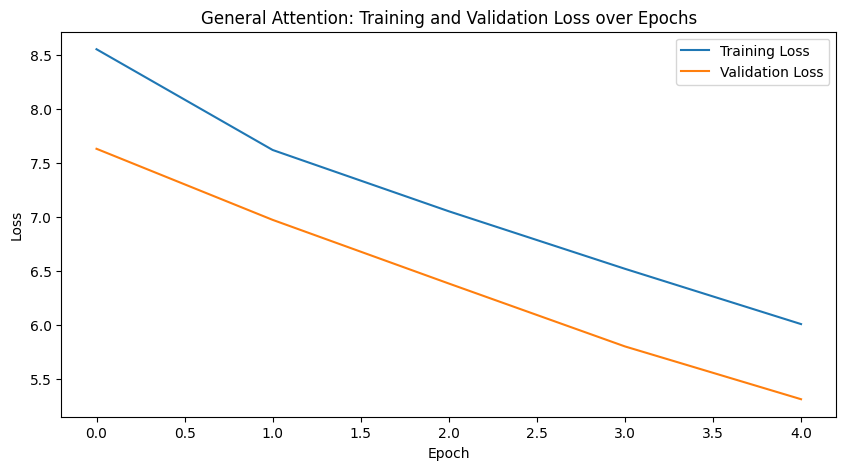

In [443]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(train_loss_general, label='Training Loss')
ax.plot(valid_loss_general, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('General Attention: Training and Validation Loss over Epochs')
ax.legend()
plt.show()

In [404]:
# state_dict  = torch.load('model/general_Seq2SeqTransformer.pt')

# model = Seq2SeqTransformer(encode, decode, src_pad_idx, trg_pad_idx, device).to(device)
# model.load_state_dict(state_dict)

# test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# print(f'Test Loss (General Attention): {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

params, state = torch.load('model/general_Seq2SeqTransformer.pt')

model = Seq2SeqTransformer(**params, device=device).to(device)

model.load_state_dict(state)

test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.542 | Test PPL: 693.810 |


## Multiplicative Attention

In [405]:
atten_type = "multiplicative"
epoch_time_tot = 0

enc = Encoder(input_dim, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, atten_type, device)

dec = Decoder(output_dim, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, atten_type, device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_loss_multi = []
valid_loss_multi = []
print(f'\n========== {atten_map[atten_type]} ==========')


for epoch in range(epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_loss_multi.append(train_loss)
    valid_loss_multi.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epoch_time_tot += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_general
final_train_loss = train_loss_multi[-1]
final_valid_loss = valid_loss_multi[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)


========== Multiplicative Attention ==========
Epoch: 01 | Time: 9m 32s
	Train Loss: 8.464 | Train PPL: 4742.886
	Val. Loss: 7.513 | Val. PPL: 1832.393
Epoch: 02 | Time: 9m 35s
	Train Loss: 7.485 | Train PPL: 1780.338
	Val. Loss: 6.751 | Val. PPL: 855.251
Epoch: 03 | Time: 9m 50s
	Train Loss: 6.863 | Train PPL: 956.478
	Val. Loss: 6.085 | Val. PPL: 439.153
Epoch: 04 | Time: 9m 56s
	Train Loss: 6.299 | Train PPL: 544.189
	Val. Loss: 5.558 | Val. PPL: 259.402
Epoch: 05 | Time: 9m 57s
	Train Loss: 5.808 | Train PPL: 333.089
	Val. Loss: 5.142 | Val. PPL: 171.090


In [406]:
average_time_per_epoch = epoch_time_tot / epochs
overall_average_time = epoch_time_tot / (epochs * len(train_loader))

print(f"Final Training Loss: {final_train_loss:.3f}")
print(f"Final Validation Loss: {final_valid_loss:.3f}")
print(f"Final Training PPL: {final_train_ppl:.3f}")
print(f"Final Validation PPL: {final_valid_ppl:.3f}")
print(f"Average Time per epoch: {average_time_per_epoch}")
print(f"Overall time taken: {overall_average_time}")

Final Training Loss: 5.808
Final Validation Loss: 5.142
Final Training PPL: 333.089
Final Validation PPL: 171.090
Average Time per epoch: 586.5707565307617
Overall time taken: 0.09385132104492187


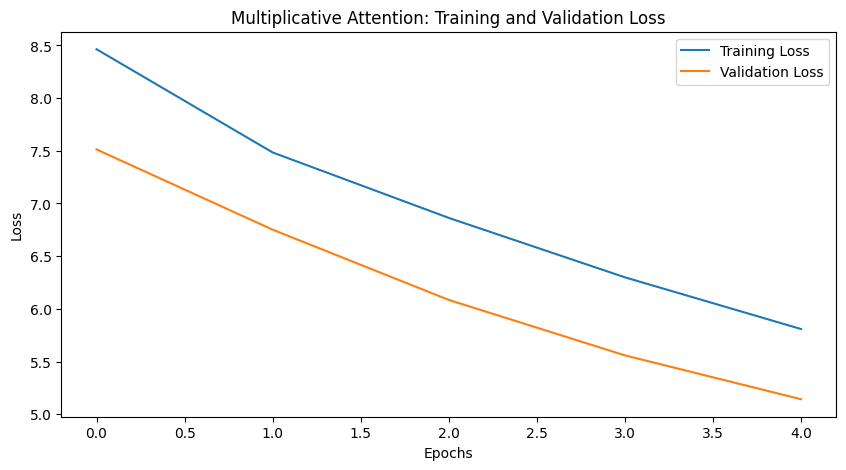

In [407]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(train_loss_multi, label='Training Loss')
ax.plot(valid_loss_multi, label='Validation Loss')

ax.set_title('Multiplicative Attention: Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()


In [408]:
params, state = torch.load('model/multiplicative_Seq2SeqTransformer.pt')

model = Seq2SeqTransformer(**params, device=device).to(device)

model.load_state_dict(state)

test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.174 | Test PPL: 479.905 |


## Additive Model

In [409]:
atten_type = "additive"
epoch_time_tot = 0

enc = Encoder(input_dim, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, atten_type, device)

dec = Decoder(output_dim, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, atten_type, device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_loss_additive = []
valid_loss_additive = []
print(f'\n========== {atten_map[atten_type]} ==========')


for epoch in range(epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_loss_additive.append(train_loss)
    valid_loss_additive.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epoch_time_tot += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_general
final_train_loss = train_loss_additive[-1]
final_valid_loss = valid_loss_additive[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)


========== Additive Attention ==========
Epoch: 01 | Time: 11m 21s
	Train Loss: 8.327 | Train PPL: 4133.094
	Val. Loss: 7.414 | Val. PPL: 1658.588
Epoch: 02 | Time: 11m 14s
	Train Loss: 7.409 | Train PPL: 1651.174
	Val. Loss: 6.695 | Val. PPL: 808.450
Epoch: 03 | Time: 11m 12s
	Train Loss: 6.793 | Train PPL: 891.677
	Val. Loss: 6.032 | Val. PPL: 416.747
Epoch: 04 | Time: 11m 10s
	Train Loss: 6.239 | Train PPL: 512.494
	Val. Loss: 5.519 | Val. PPL: 249.343
Epoch: 05 | Time: 10m 31s
	Train Loss: 5.762 | Train PPL: 317.919
	Val. Loss: 5.104 | Val. PPL: 164.610


In [410]:
average_time_per_epoch = epoch_time_tot / epochs
overall_average_time = epoch_time_tot / (epochs * len(train_loader))

print(f"Final Training Loss: {final_train_loss:.3f}")
print(f"Final Validation Loss: {final_valid_loss:.3f}")
print(f"Final Training PPL: {final_train_ppl:.3f}")
print(f"Final Validation PPL: {final_valid_ppl:.3f}")
print(f"Average Time per epoch: {average_time_per_epoch}")
print(f"Overall time taken: {overall_average_time}")

Final Training Loss: 5.762
Final Validation Loss: 5.104
Final Training PPL: 317.919
Final Validation PPL: 164.610
Average Time per epoch: 666.0630418777466
Overall time taken: 0.10657008670043945


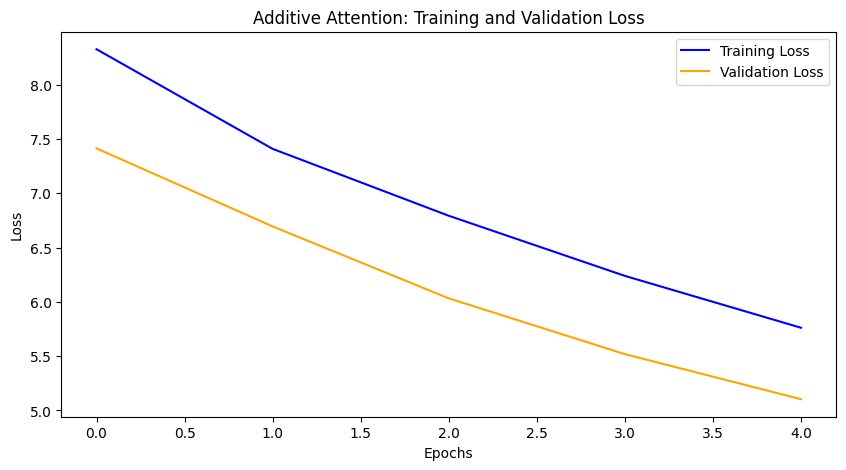

In [441]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(train_loss_additive, label='Training Loss', color='blue')
ax.plot(valid_loss_additive, label='Validation Loss', color='orange')

ax.set_title('Additive Attention: Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

In [412]:
params, state = torch.load('model/additive_Seq2SeqTransformer.pt')

model = Seq2SeqTransformer(**params, device=device).to(device)

model.load_state_dict(state)

test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test PPL: {math.exp(test_loss):7.3f}")

Test Loss: 6.368
Test PPL: 583.169


## Testing

In [413]:
import os

dataset['test'][12]


{'ne': 'यो सूचीले प्लगइनहरू समावेश सबै अन्य डाइरेक्टरीहरू छन्।',
 'en': 'This list contains all extra directories containing plugins.'}

In [414]:
src_txt = text_transform[SRC_LANG](dataset['test'][12]['en']).to(device)

src_txt

tensor([   2,    0,   51,  314,   45, 1163,  816,  837,  500,    5,    3])

In [415]:
targ_txt = text_transform[TARG_LANG](dataset['test'][12]['ne']).to(device)
targ_txt

tensor([  2,   4,  35,  92,  86, 219, 123, 131,  12, 591,  76, 323, 181,  27,
         12, 583,   6,   5,   3])

In [416]:
src_txt = src_txt.reshape(1, -1)   # because batch size is 1
targ_txt = targ_txt.reshape(1, -1) # because batch size is 1

src_txt.shape, targ_txt.shape

(torch.Size([1, 11]), torch.Size([1, 19]))

In [417]:
text_length = torch.tensor([src_txt.size(0)]).to(dtype=torch.int64)
text_length

tensor([1])

## Testing General Model

In [418]:
load_path = 'model/general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()



Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(17110, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [419]:
start_time = time.time()
with torch.no_grad():
    output, attentions_general = model(src_txt, targ_txt) #turn off teacher forcing

end_time = time.time()


elapsed_time = end_time - start_time

print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size (MB)

print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.010998964309692383 seconds
Model size: 51.79 MB


since `batch_size` is 1, we just squeeze the first dimension .i.e. take off that dimension 

In [420]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 19, 10018])

In [421]:
output = output.squeeze(0)
output.shape

torch.Size([19, 10018])

We shall remove the first token since it's zeros anyway

In [422]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([18, 10018])

Then we just take the top token with highest probabilities

In [423]:
output

tensor([[ 0.1711, -0.3709, -0.0196,  ..., -0.2504, -0.3429, -0.0316],
        [ 0.1607, -0.4128, -0.1536,  ..., -0.1423, -0.4181,  0.0065],
        [ 0.1902, -0.3572, -0.0935,  ..., -0.1881, -0.3836,  0.0367],
        ...,
        [ 0.3302, -0.3101, -0.0303,  ..., -0.1732, -0.4555, -0.0811],
        [ 0.1519, -0.3045, -0.0914,  ..., -0.0882, -0.3762, -0.0168],
        [ 0.2739, -0.3000, -0.0535,  ..., -0.2453, -0.3707, -0.0495]])

In [424]:
output_max = output.argmax(1) #returns max indices
output_max

tensor([1669,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5])

Get the mapping of the target language

In [425]:
mapping = vocab_transform[TARG_LANG].get_itos()

output_general = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_general.append(token_str)

en
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]


In [426]:
mapping[:10]

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 '[CLS]',
 '[SEP]',
 '।',
 'गर्नुहोस्',
 ':',
 '##होस्']

In [427]:
print(output_general)

['en']


## Testing Multiplicative Model

In [428]:
load_path = 'model/multiplicative_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()

start_time = time.time()
with torch.no_grad():
    output, attentions_multiplicative = model(src_txt, targ_txt) #turn off teacher forcing

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size (MB)

print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.009573936462402344 seconds
Model size: 51.79 MB


In [429]:
output.shape #batch_size, trg_len, trg_output_dim
output = output.squeeze(0)
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([18, 10018])

In [430]:
output_max = output.argmax(1) #returns max indices
output_max

tensor([1669,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3])

In [431]:
mapping = vocab_transform[TARG_LANG].get_itos()

In [432]:
output_multi = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_multi.append(token_str)

en
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>


In [433]:
print(output_multi)

['en']


## Testing Additive model

In [434]:
load_path = 'model/additive_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()

start_time = time.time()
with torch.no_grad():
    output, attentions_additive = model(src_txt, targ_txt) #turn off teacher forcing

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size (MB)

print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.013999223709106445 seconds
Model size: 51.79 MB


In [435]:
output.shape #batch_size, trg_len, trg_output_dim
output = output.squeeze(0)
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([18, 10018])

In [436]:
output_max = output.argmax(1) #returns max indices

In [437]:
mapping = vocab_transform[TARG_LANG].get_itos()

In [438]:
output_addi = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_addi.append(token_str)

en
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
[SEP]
<eos>
[SEP]


In [439]:
print(output_addi)

['en']


In [440]:
# Observation Performance Comparison

## Attention

In [444]:
attentions_general.shape, attentions_multiplicative.shape, attentions_additive.shape

(torch.Size([1, 8, 19, 11]),
 torch.Size([1, 8, 19, 11]),
 torch.Size([1, 8, 19, 11]))

In [445]:
attention_general = attentions_general[0, 0, :, :]
attention_multiplicative = attentions_general[0, 0, :, :]
attention_additive = attentions_additive[0, 0, :, :]

print(attentions_general.shape, attention_multiplicative.shape, attention_additive.shape)

torch.Size([1, 8, 19, 11]) torch.Size([19, 11]) torch.Size([19, 11])


In [446]:
src_tokens = ['<sos>'] + token_transform[SRC_LANG](dataset['test'][1]['en']) + ['<eos>']
src_tokens

['<sos>', 'Treize', '<eos>']

In [447]:
targ_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
targ_tokens

['<sos>',
 'en',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '[SEP]',
 '<eos>',
 '[SEP]']

## Attention Maps

In [455]:
import matplotlib.ticker as ticker
import numpy as np
def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(25, 15))
    ax = fig.add_subplot(111)

    attention = (
        attention
        .squeeze(1)
        .detach()
        .cpu()
        # .numpy()
        .tolist()
    )

    cax = ax.matshow(attention, cmap='bone')
    ax.tick_params(labelsize=10)

    ax.set_xticks(range(len(sentence) + 1))
    ax.set_yticks(range(len(translation) + 1))

    ax.set_xticklabels([''] + sentence, rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


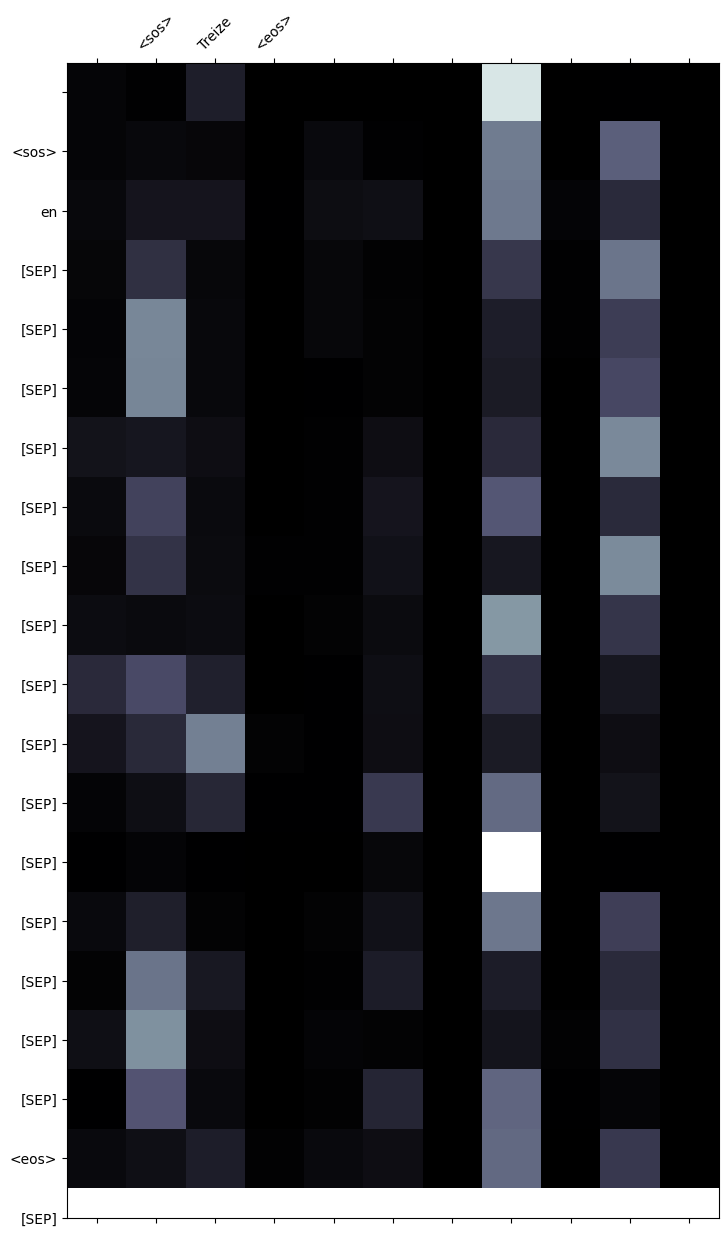

In [456]:
display_attention(src_tokens, targ_tokens, attention_multiplicative)

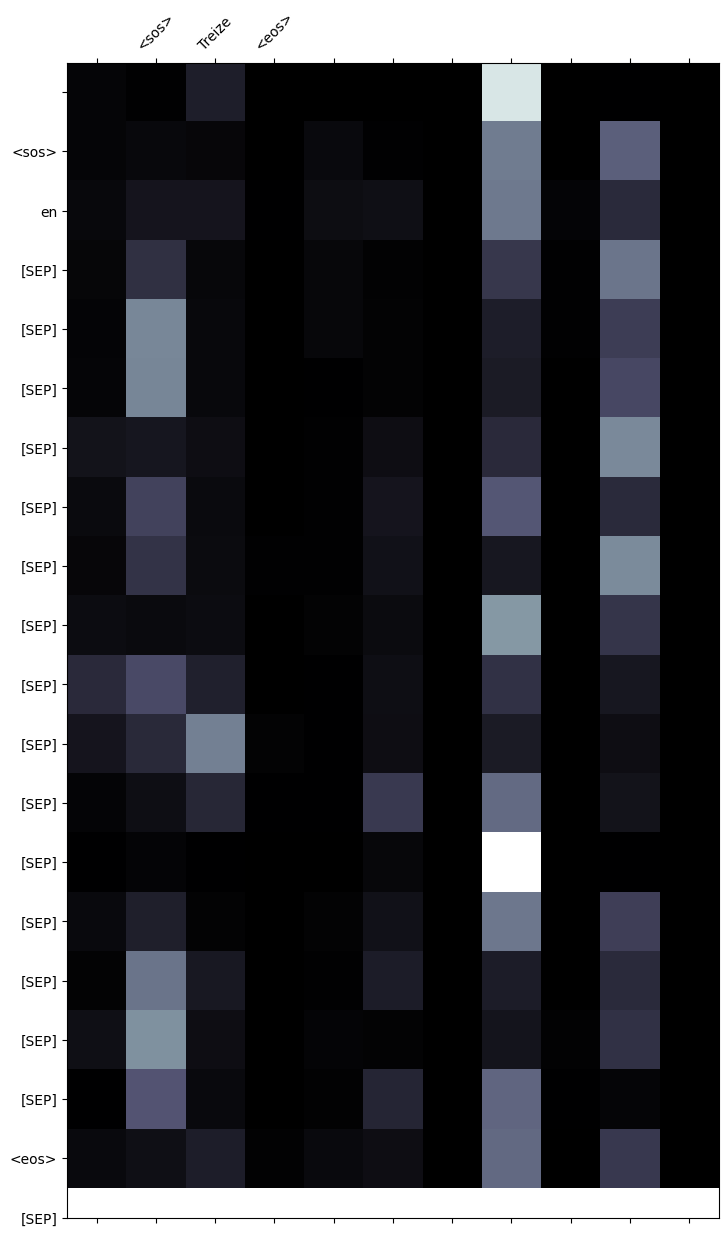

In [457]:
display_attention(src_tokens, targ_tokens, attention_general)

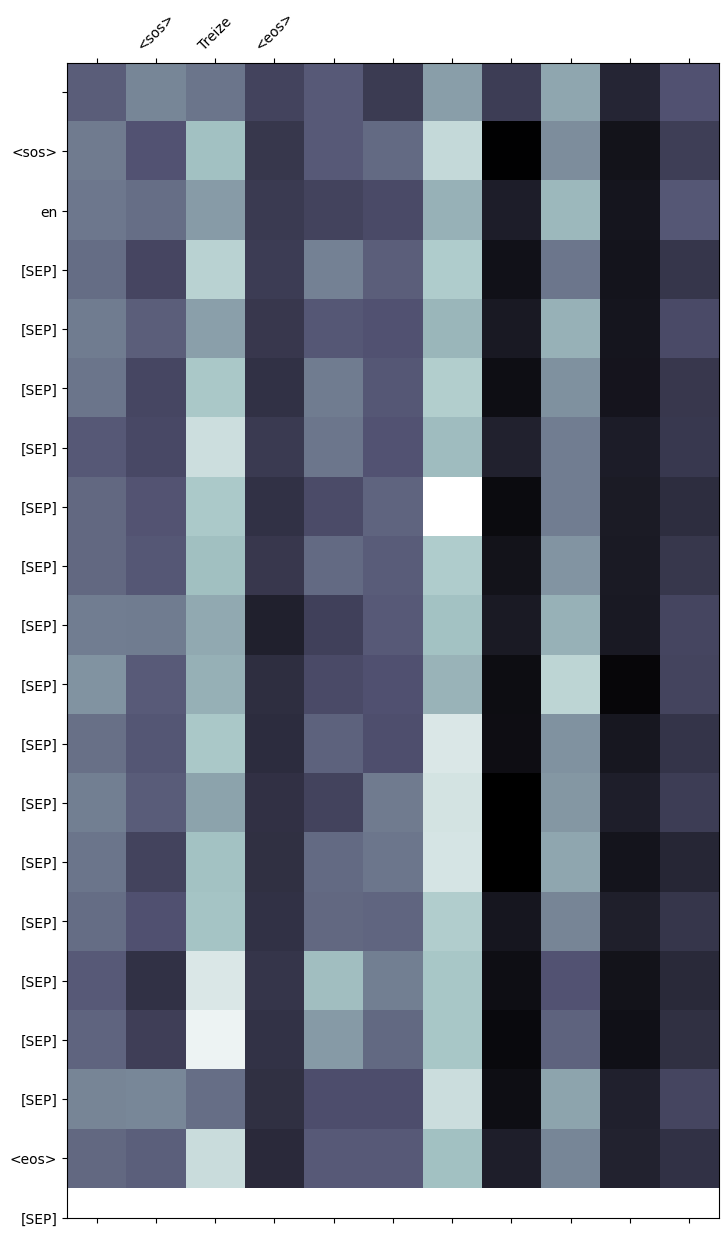

In [458]:
display_attention(src_tokens, targ_tokens, attention_additive)

## Analysis of Results

Based on the experimental evaluation discussed in the previous sections, **Multiplicative Attention** achieved the lowest loss and perplexity values during both training and validation. Consequently, this attention mechanism was selected for integration into the web application.

Despite the relative performance differences among the three attention variants, the overall translation quality remains limited. This may be attributed to factors such as a small number of training epochs, limited dataset size, or potential overfitting. Further tuning and extended training could improve the translation accuracy.

---

## Web Application Architecture and Interface Documentation

For this assignment, the web application was implemented using a **React frontend** and a **Django backend**. The frontend is responsible for handling user interactions, while the backend manages model inference and translation logic. This separation of concerns ensures better scalability, maintainability, and extensibility of the application.

### Backend (Django)

The backend is developed using **Django** along with **Django REST Framework (DRF)** to expose a RESTful API endpoint for translation. The trained Transformer model with **Multiplicative Attention** is loaded during server initialization. The vocabulary is restored using PyTorch’s `.load` method, and the model is reconstructed by passing the appropriate architectural parameters before loading the trained weights.

When a translation request is received, the backend performs the following steps:

1. Tokenization of the input sentence.
2. Numericalization using the loaded vocabulary.
3. Conversion of tokens into tensors suitable for the model.
4. Autoregressive decoding, where at each step the token with the highest probability is selected.
5. Detokenization of the predicted token sequence to generate the final translated sentence.

The translated output is returned to the frontend in JSON format.

---

### Frontend (React)

The frontend interface is implemented using **React** and provides a simple and intuitive user experience. It consists of:

- An input field for entering the source sentence.
- A translate button to submit the request.
- Basic input validation.
- A result section to display the translated sentence.

The frontend communicates with the Django backend via HTTP requests. Upon receiving the translation response, the result is rendered dynamically on the screen.

---

### User Interaction Flow

1. The user enters an English sentence into the input field.
2. The user clicks the **Translate** button.
3. The frontend sends the input sentence to the Django backend via an API request.
4. The backend processes the request and generates the translation.
5. The translated sentence is returned and displayed to the user.

---

## Conclusion

This assignment presented the implementation and evaluation of an English-to-Nepali Transformer-based translation system using different attention mechanisms. Among the evaluated variants, **Multiplicative Attention** demonstrated superior performance and was therefore selected for deployment in the web application.

Future work may focus on increasing the number of training epochs, enhancing data preprocessing techniques, incorporating regularization strategies, or experimenting with more advanced Transformer architectures to further improve translation quality and robustness.
